In [1]:
import os
import numpy as np

from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import InPort, OutPort

from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.nc.ports import NcInPort, NcOutPort
from lava.magma.core.model.nc.type import LavaNcType

try:
    from lava.magma.core.model.nc.net import NetL2
except ImportError:
    class NetL2:
        pass

from lava.magma.core.model.nc.tables import Nodes
from lava.magma.core.resources import NeuroCore, Loihi2NeuroCore
from lava.magma.core.decorator import implements, requires, tag
from lava.magma.core.model.nc.model import AbstractNcProcessModel
from lava.magma.core.model.nc.var import NcVar


### FOR CPU IMPLEMENTATION
from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.resources import CPU 
from lava.magma.core.model.py.model import PyLoihiProcessModel
from lava.magma.core.run_configs import Loihi1SimCfg


# No support fot HW yet from lava.proc.monitor.process import Monitor
import matplotlib.pyplot as plt


In [2]:
class IzhikevichProc(AbstractProcess):
    """Simple Asm Process"""

    def __init__(self, shape, randomize=False,**kwargs):
        super().__init__() 
        
        shape = kwargs.get("shape", (1,))
        fraction = kwargs.get("fraction", 2**10)
         
        self.shape = shape
        self.a_in = InPort(shape=shape) 
        
        self.s_out = OutPort(shape=shape)
  
        self.v    = Var(shape=shape, init=kwargs.pop("v", -70*fraction*np.ones(shape = shape, dtype=np.int32)))
        self.u    = Var(shape=shape, init=kwargs.pop("u", -12*fraction*np.ones(shape = shape, dtype=np.int32))) 
        self.Iconst = Var(shape=shape, init=kwargs.pop("Iconst", 0*fraction*np.ones(shape = shape, dtype=np.int16))) 
         
        self.vp  = Var(shape=shape, init=kwargs.pop("vp", 30*fraction*np.ones(shape = shape, dtype=np.int32)))
        
        self.a = Var(shape=shape, init=kwargs.pop("a", 0.02*fraction*np.ones(shape = shape, dtype=np.int16)))
        self.b = Var(shape=shape, init=kwargs.pop("b", 0.2*fraction*np.ones(shape = shape, dtype=np.int16)))
        self.c = Var(shape=shape, init=kwargs.pop("c", -65*fraction*np.ones(shape = shape, dtype=np.int32)))
        self.d = Var(shape=shape, init=kwargs.pop("d", 8*fraction*np.ones(shape = shape, dtype=np.int32)))
        
        
        self.proc_params["shape"] = shape
        
        
    # Print function for debugging
    def print_vars(self):
        """Prints all variables of a Izhikevich process and their values."""

        print("Variables of the Izhikevich:") 
        print("v: ", str(self.v.get())) 

In [3]:
param_a = np.round(0.1*2**12)
param_b = np.round(0.2*2**12)  
param_d = 2
print(param_a)
print(param_b)
I = 5

num_step = 300 #ms
step_per_cycle = 1

410.0
819.0


In [4]:
@implements(proc=IzhikevichProc, protocol=LoihiProtocol)
@requires(CPU)
@tag('floating_pt')
class PyIzhikevichModelFloat(PyLoihiProcessModel):
    #I_ext      : PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    a_in : PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)  
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, bool,precision = 1)
    
    u: np.ndarray = LavaPyType(np.ndarray, float)
    v: np.ndarray = LavaPyType(np.ndarray, float)
    
    Iconst: np.ndarray = LavaPyType(np.ndarray, float)
    a: np.ndarray = LavaPyType(np.ndarray, float)
    b: np.ndarray = LavaPyType(np.ndarray, float)
    c: np.ndarray = LavaPyType(np.ndarray, float)
    d: np.ndarray = LavaPyType(np.ndarray, float)
     
          
    vp: np.ndarray = LavaPyType(np.ndarray, float) 
    
      
    def run_spk(self):
        
        #I_ext = self.I_ext.recv()
        
        dt = 1/8
           
        v_old = self.v
        u_old = self.u
        self.v[:] = v_old + ((164/4096)*np.square(v_old) + 5*v_old + 140 - u_old + self.Iconst)*dt 
        self.u[:] = u_old + ((self.a)*(self.b*v_old - u_old))*dt
          
        is_spike = self.v >= self.vp 
        self.v[:] = self.v*(~is_spike) + self.c*is_spike
        self.u[:] = self.u + self.d*is_spike
        
        self.s_out.send(is_spike)

perc :  0.0
perc :  10.0
perc :  20.0
perc :  30.0
perc :  40.0
perc :  50.0
perc :  60.0
perc :  70.0
perc :  80.0
perc :  90.0


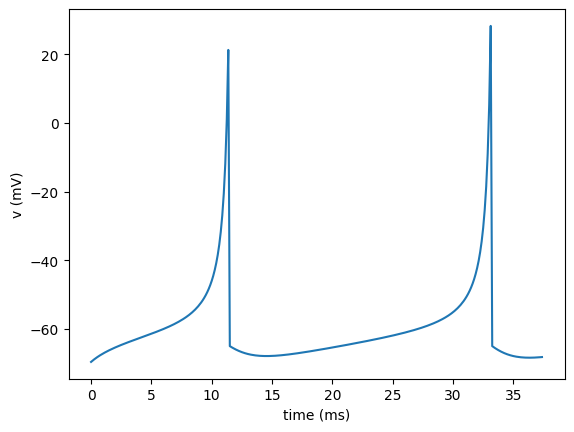

In [5]:
from lava.magma.core.run_conditions import RunSteps

shape = (1,) 

fraction = 2**0
Iconst = I*fraction*np.ones(shape = shape) 
a = param_a / (2**12) *np.ones(shape = shape)
b = param_b / (2**12) *np.ones(shape = shape)
c = -65 *np.ones(shape = shape)
d =  param_d *np.ones(shape = shape)
vp = 30*np.ones(shape = shape)
v = -70*np.ones(shape = shape)
u = -12*np.ones(shape = shape)
nrnIzh = IzhikevichProc(shape= shape,fraction=fraction, Iconst = Iconst, a = a, b= b, c=c, d=d, vp=vp, v=v,u=u )#

data_v_float = []
data_u_float = []
 
for i in range(0,num_step): 
    nrnIzh.run(condition=RunSteps(num_steps=step_per_cycle), run_cfg=Loihi1SimCfg(select_tag='floating_pt'))
    
    if i%int(num_step*0.1) == 0:
        
        print("perc : ", i/num_step*100)
     
    data_v_float.append(float(nrnIzh.v.get())/fraction)
    data_u_float.append(float(nrnIzh.u.get())/fraction) 

nrnIzh.stop() 
plt.plot(np.arange(0,len(data_v_float))/8*step_per_cycle,data_v_float)
plt.xlabel('time (ms)')
plt.ylabel('v (mV)')
plt.show()

In [6]:
@implements(proc=IzhikevichProc, protocol=LoihiProtocol)
@requires(CPU)
@tag('fixed_pt')
class PyIzhikevichModelFixed(PyLoihiProcessModel):
    #I_ext      : PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
     
    a_in : PyInPort = LavaPyType(PyInPort.VEC_DENSE, np.int16, precision=16)  
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE,  np.int32, precision=24)
    
    u: np.ndarray = LavaPyType(np.ndarray,  np.int32, precision=24)
    v: np.ndarray = LavaPyType(np.ndarray,  np.int32, precision=24)
    
    Iconst: np.ndarray = LavaPyType(np.ndarray, np.int16, precision=16)
    a: np.ndarray = LavaPyType(np.ndarray, np.int16, precision=16)
    b: np.ndarray = LavaPyType(np.ndarray, np.int16, precision=16)
    c: np.ndarray = LavaPyType(np.ndarray,  np.int32, precision=24)
    d: np.ndarray = LavaPyType(np.ndarray, np.int32, precision=24)
     
          
    vp: np.ndarray = LavaPyType(np.ndarray,  np.int32, precision=24) 
    
    def mult_fract_shift(self, a,b,fract):
        res = np.int64(a)
        res = np.int64(res*b)
        res = np.int64(np.right_shift(res,fract)) #res = np.int64(np.floor(res/2**fract))
        return np.int32(res)
    
    def mult_fract(self, a,b,fract):
        res = np.int64(a)
        res = np.int64(res*b)
        res = np.sign(res) * np.right_shift(np.abs(res), fract)  
        return np.int32(res)
    
    def run_spk(self):
         
        
        dt_bit = 3  #1/8 ms
        fraction_bit = 12
           
        v_old = self.v
        u_old = self.u  
        
        dv = self.mult_fract(v_old, np.int32(round(0.04*2**fraction_bit)), fraction_bit) 
        dv = self.mult_fract(dv, v_old, fraction_bit) 
        
        v_five = self.mult_fract(v_old, np.int32(5*2**fraction_bit), fraction_bit)
        dv = dv +  v_five + np.int32(140*2**fraction_bit) - u_old + self.Iconst
        dv = np.sign(dv) * np.right_shift(np.abs(dv), dt_bit)#np.right_shift(dv, dt_bit)#np.sign(dv) * np.right_shift(np.abs(dv), dt_bit)
        dv = np.int32(dv)
        
                             
        du = self.mult_fract( v_old,self.b, fraction_bit)
        du = self.mult_fract( du - u_old,self.a, fraction_bit)
        du = np.sign(du) * np.right_shift(np.abs(du), dt_bit) #np.right_shift(du, dt_bit)
        du = np.int32(du)
        
        self.v[:] = v_old + dv
        self.u[:] = u_old + du
                             
         
        is_spike = self.v >= self.vp 
        self.v[:] = self.v*(~is_spike) + self.c*is_spike
        self.u[:] = self.u + self.d*is_spike
        
        self.s_out.send(is_spike)

perc :  0.0
perc :  10.0
perc :  20.0
perc :  30.0
perc :  40.0
perc :  50.0
perc :  60.0
perc :  70.0
perc :  80.0
perc :  90.0


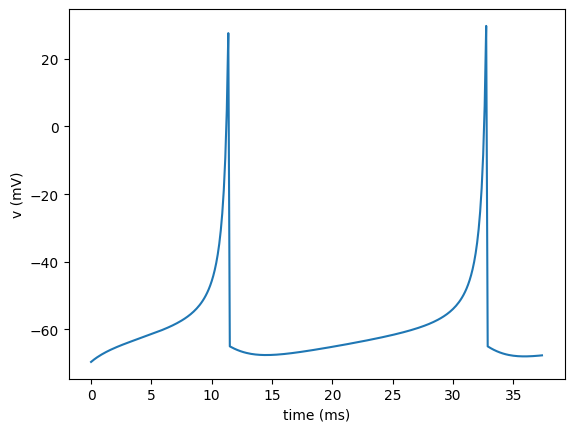

In [7]:
from lava.magma.core.run_conditions import RunSteps

shape = (1,)
dt = 1/8

fraction = 2**12
Iconst = np.int16(I*fraction)*np.ones(shape = shape, dtype=np.int16) 
a = np.int16(param_a)*np.ones(shape = shape, dtype=np.int16) 
b = np.int16(param_b)*np.ones(shape = shape, dtype=np.int16)
c = np.int32(-65*2**12)*np.ones(shape = shape, dtype=np.int32)
d = np.int32(param_d*2**12)*np.ones(shape = shape, dtype=np.int32)
vp = np.int32(30*2**12)*np.ones(shape = shape, dtype=np.int32)
v = np.int32(-70*2**12)*np.ones(shape = shape, dtype=np.int32)
u = np.int32(-12*2**12)*np.ones(shape = shape, dtype=np.int32)

nrnIzh = IzhikevichProc(shape= shape,fraction=fraction, Iconst = Iconst, a = a, b=b, c=c, d=d, vp=vp, v=v,u=u )

data_v_fixed = []
data_u_fixed = []
 
for i in range(0,num_step): 
    nrnIzh.run(condition=RunSteps(num_steps=step_per_cycle), run_cfg=Loihi1SimCfg(select_tag='fixed_pt'))
    
    if i%np.ceil(num_step*0.1) == 0:
        
        print("perc : ", i/num_step*100)
     
    data_v_fixed.append(float(nrnIzh.v.get())/fraction)
    data_u_fixed.append(float(nrnIzh.u.get())/fraction) 

nrnIzh.stop() 
plt.plot(np.arange(0,len(data_v_fixed))/8*step_per_cycle,data_v_fixed)
plt.xlabel('time (ms)')
plt.ylabel('v (mV)')
plt.show()
plt.show()

In [8]:
@implements(proc=IzhikevichProc, protocol=LoihiProtocol)
@requires(Loihi2NeuroCore)
@tag("ucoded")
class IzhikevichModHw(AbstractNcProcessModel):
    
    """
    RESTRICTED DUE TO CONFIDENTIALITY ISSUE
    """


In [9]:
from lava.utils.system import Loihi2
Loihi2.preferred_partition =  'oheogulch'
loihi2_is_available = Loihi2.is_loihi2_available
print(loihi2_is_available)


True


Per core distribution:
----------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Cores |
|--------------------------------------------------------------|
|       0|       1|       1|       0|       1|       0|       1|
|--------------------------------------------------------------|
| Total                                               |       1|
----------------------------------------------------------------
perc :  0.0
perc :  10.0
perc :  20.0
perc :  30.0
perc :  40.0
perc :  50.0
perc :  60.0
perc :  70.0
perc :  80.0
perc :  90.0


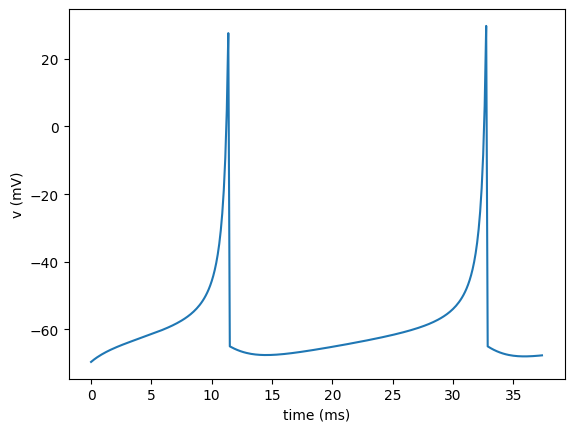

In [10]:
shape = (1,)
dt = 1/8
fraction = 2**12 #10 bit fraction
Iconst = np.int16(I*fraction)*np.ones(shape = shape, dtype=np.int16) 
a = np.int16(param_a)*np.ones(shape = shape, dtype=np.int16) 
b = np.int16(param_b)*np.ones(shape = shape, dtype=np.int16)
c = np.int32(-65*2**12)*np.ones(shape = shape, dtype=np.int32)
d = np.int32(param_d*2**12)*np.ones(shape = shape, dtype=np.int32)
vp = np.int32(30*2**12)*np.ones(shape = shape, dtype=np.int32)
v = np.int32(-70*2**12)*np.ones(shape = shape, dtype=np.int32)
u = np.int32(-12*2**12)*np.ones(shape = shape, dtype=np.int32)
nrnIzh = IzhikevichProc(shape= shape,fraction=fraction, Iconst = Iconst , a = a, b=b, c=c, d=d, vp=vp, v=v,u=u)#

"""    
Monitor not supported for HW yet
monitor1 = Monitor()
monitor1.probe(target=nrnIzh.v, num_steps=1000)
"""

# Execute process lif1 and all processes connected to it for fixed number of steps
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2HwCfg

data_v = []
data_u = []

"""
RUN ON HW
"""
 
for i in range(0,num_step):#num_step): 
    nrnIzh.run(condition=RunSteps(num_steps=step_per_cycle), run_cfg=Loihi2HwCfg(select_tag='ucoded'))
    
    if i%int(num_step*0.1) == 0:
        
        print("perc : ", i/num_step*100)
     
    data_v.append(float(nrnIzh.v.get())/fraction)
    data_u.append(float(nrnIzh.u.get())/fraction) 

"""    
Monitor not supported for HW yet 
"""
nrnIzh.stop() 
#plt.plot(np.arange(num_steps1*dt,(num_steps1+num_steps2)*dt,dt),data_v)
plt.plot(np.arange(0,len(data_v))/8*step_per_cycle,data_v)
plt.xlabel('time (ms)')
plt.ylabel('v (mV)')
plt.show()
plt.show()

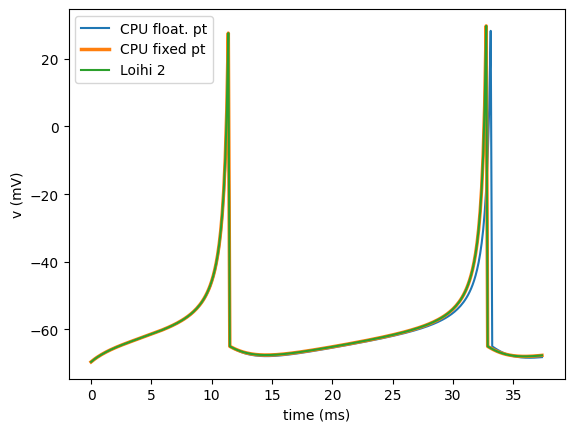

In [11]:
plt.plot(np.arange(0,len(data_v_float))/8*step_per_cycle,data_v_float, label='CPU float. pt')
plt.plot(np.arange(0,len(data_v_fixed))/8*step_per_cycle,data_v_fixed, label='CPU fixed pt',linewidth=2.5)
plt.plot(np.arange(0,len(data_v))/8*step_per_cycle,data_v, label='Loihi 2')
plt.xlabel('time (ms)')
plt.ylabel('v (mV)')
plt.legend(loc='upper left')
plt.savefig('spiketimings.svg') 
plt.show()

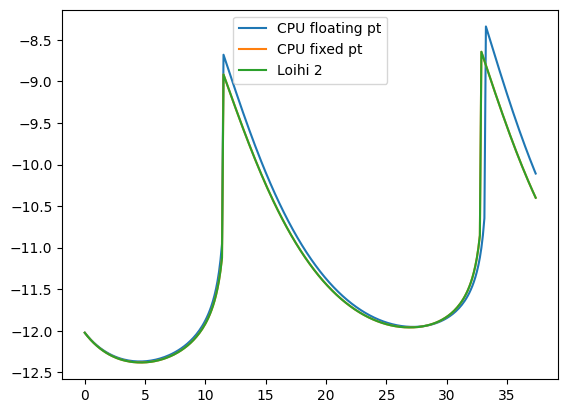

In [12]:
plt.plot(np.arange(0,len(data_v))/8*step_per_cycle,data_u_float, label='CPU floating pt')
plt.plot(np.arange(0,len(data_v))/8*step_per_cycle,data_u_fixed, label='CPU fixed pt')
plt.plot(np.arange(0,len(data_v))/8*step_per_cycle,data_u, label='Loihi 2')
plt.legend()
plt.show()

In [24]:
#Find spiking times
orgnl =np.array(data_v_float)
lo_data = np.array(data_v)

redge = (orgnl[1:-1]-orgnl[2:]) >0
ledge = (orgnl[1:-1]-orgnl[:-2]) >0
 
spk_inds_float = np.where(redge * ledge)

print(spk_inds_float)

redge = (lo_data[1:-1]-lo_data[2:]) >0
ledge = (lo_data[1:-1]-lo_data[:-2]) >0

#print(ledge)
spk_inds_lo = np.where(redge * ledge)
print(spk_inds_lo)

#Calculate ERRT
delta_fl = spk_inds_float[0][1] - spk_inds_float[0][0]
delta_lo = spk_inds_lo[0][1] - spk_inds_lo[0][0]

ERRT = abs(delta_lo-delta_fl)/delta_fl*100
print("ERRT of Loihi 2 = %", ERRT)

(array([ 90, 264]),)
(array([ 90, 261]),)
ERRT of Loihi 2 = % 1.7241379310344827


In [25]:
#Find spiking times
fx_data = np.array(data_v_fixed)
redge = (fx_data[1:-1]-fx_data[2:]) >0
ledge = (fx_data[1:-1]-fx_data[:-2]) >0

#Calculate ERRT
spk_inds_fx = np.where(redge * ledge)
print(spk_inds_fx)
delta_fx = spk_inds_fx[0][1] - spk_inds_fx[0][0]

ERRT2 = abs(delta_fx-delta_fl)/delta_fl*100
print("ERRT2 of Fixed Point CPU = %", ERRT2)

(array([ 90, 261]),)
ERRT2 of Fixed Point CPU = % 1.7241379310344827
